In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk import sent_tokenize, word_tokenize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:

df.head()

,headline,label
0,"you are such a loser, no one cares",-1
1,Great Job on your presentation,-1
2,fuck your filthy mother in the ass dry,-1
3,get fuck ed up get fuck ed up got a drink t...,-1
4,stupid peace of shit stop deleting my stuff ...,-1


In [99]:
df['label'].unique()

array([ 2, -1,  0], dtype=int64)

Dataframe manipulation


In [100]:
def perform_data_manipulation():
    df = pd.read_csv("dataset.csv")
    
    for index in df.index:
        if df.loc[index, "label"]==-1:
            df.loc[index, "label"] = 1
    return df

In [101]:
df = perform_data_manipulation()

In [102]:
df.head()

,headline,label
0,"you are such a loser, no one cares",2
1,Great Job on your presentation,1
2,fuck your filthy mother in the ass dry,1
3,get fuck ed up get fuck ed up got a drink t...,1
4,stupid peace of shit stop deleting my stuff ...,1


In [103]:
df['label'].unique()

array([2, 1, 0], dtype=int64)

In [104]:
df.shape[0]

18148

Classification using Pie Chart

In [105]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_toxic = df[df['label']==0].shape[0]
    
    slices = [num_non_toxic/total, (total-num_non_toxic)/total]
    
    labeling = ['Non-Toxic', 'Toxic']
    
    explode = [0.2, 0]
    
    plt.pie(slices, explode = explode, shadow=True, autopct="%1.1f%%", labels = labeling, wedgeprops={'edgecolor': 'black'})
    
    plt.title('Number of Toxic Vs Non- Toxic Test Sample')
    
    plt.tight_layout()
    
    plt.show()

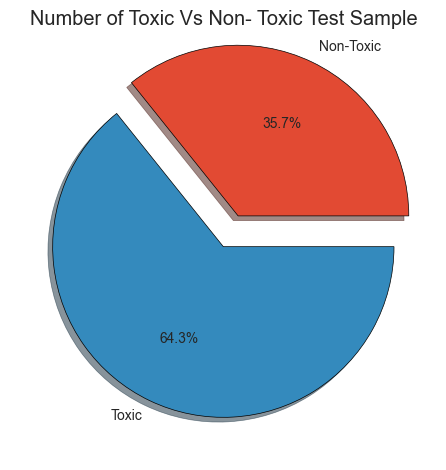

In [106]:
performdatadistribution(df)

In [107]:
def remove_pattern(input_txt, pattern):
    if (type(input_txt)==str):
        r = re.findall(pattern, input_txt)
        for i in r:
            input_txt = re.sub(i, '', input_txt)
        return input_txt
    else:
        return ""

In [108]:
df.head(1)

,headline,label
0,"you are such a loser, no one cares",2


In [109]:
def datasetCleaning(df):
    # Add a column for the length of the headlines
    df['length_headline'] = df['headline'].str.len()
    
    # Combine the dataframe with itself
    combined_df = pd.concat([df, df], ignore_index=True)
    
    # Remove @user patterns
    combined_df['tidy_tweet'] = np.vectorize(remove_pattern)(combined_df['headline'], "@[\w]*")
    
    # Remove non-alphabetic characters
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ", regex=True)
    
    # Remove all words with length less than 3
    combined_df['tidy_tweet'] = combined_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))
    
    # Add a column for the length of the cleaned tweets
    combined_df['length_tidy_tweet'] = combined_df['tidy_tweet'].str.len()
    
    # Tokenize the tweets
    tokenized_tweet = combined_df['tidy_tweet'].apply(lambda x: x.split())
    
    # Download NLTK WordNet data (if not already downloaded)
    nltk.download('wordnet')
    
    # Lemmatize tokens
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    
    # Join tokens back into sentences
    tokenized_tweet = tokenized_tweet.apply(lambda x: ' '.join(x))
    combined_df['tidy_tweet'] = tokenized_tweet
    
    return combined_df, df

In [110]:
# Call the function
combined_df, df = datasetCleaning(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [111]:
combined_df.head()

,headline,label,length_headline,tidy_tweet,length_tidy_tweet
0,"you are such a loser, no one cares",2,34,such loser care,16
1,Great Job on your presentation,1,30,Great your presentation,23
2,fuck your filthy mother in the ass dry,1,39,fuck your filthy mother,23
3,get fuck ed up get fuck ed up got a drink t...,1,121,fuck fuck drink that cant down fuck fuck fuck ...,51
4,stupid peace of shit stop deleting my stuff ...,1,93,stupid peace shit stop deleting stuff hole fal...,57


Dataset Splitting

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
def performdatasplit(x, y, combined_df, df):
    X_train, X_test, y_train, y_test = train_test_split(combined_df['tidy_tweet'], combined_df['label'], test_size = x, random_state = y)
    print(f"Number of rows in the total dataset: {combined_df.shape[0]}")
    print(f"Number of rows in the train dataset: {X_train.shape[0]}")
    print(f"Number of rows in the test dataset: {X_test.shape[0]}")
    
    files = open("stopwords.txt" , "r")
    content = files.read()
    content_list = content.split("\n")
    files.close()
    
    tfidfvector = TfidfVectorizer(stop_words=content_list, lowercase=True)
    
    training_data = tfidfvector.fit_transform(X_train.values.astype('U'))
    
    testing_data = tfidfvector.transform(X_test.values.astype('U'))
    
    filename = 'tfidfvectoizer.pkl'
    
    pickle.dump(tfidfvector.vocabulary_, open(filename, 'wb'))
    
    return X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list

In [114]:
X_train , X_test, y_train, y_test, testing_data, filename, training_data, content_list = performdatasplit(0.2, 42, combined_df, df)

Number of rows in the total dataset: 36296
Number of rows in the train dataset: 29036
Number of rows in the test dataset: 7260


C:\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ninad'] not in stop_words.
  warnings.warn(


Apply Machine Learning Algorithm

In [115]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [121]:
def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [LinearSVC(), LogisticRegression(), MultinomialNB(), DecisionTreeClassifier(),
              AdaBoostClassifier(), BaggingClassifier(), SGDClassifier()]
    
    size = len(y_train)
    
    results = {}
    
    final_result = []
    
    for model in MODELS:
        results['Algorithm'] = model.__class__.__name__
        
        start = time()
        print(f"Training Time : {model.__class__.__name__}")
        model.fit(X_train, y_train)
        end = time()
        
        filename = model.__class__.__name__+".pkl"
        pickle.dump(model, open(filename, "wb"))
        
        results['Training Time'] = end - start
        
        start = time()
        prediction_test = model.predict(X_test)
        prediction_train = model.predict(X_train)
        end = time()
        
        results['Prediction Time'] = end - start
        
        results['Accuracy : Test'] = accuracy_score(y_test, prediction_test)
        results['Accuracy : Train'] = accuracy_score(y_train, prediction_train)
        
        results['F1 Score : Test'] = f1_score(y_test, prediction_test, average='weighted')
        results['F1 Score : Train'] = f1_score(y_train, prediction_train, average='weighted')
        
        results['Precision : Test'] = precision_score(y_test, prediction_test, average='weighted')
        results['Precision : Train'] = precision_score(y_train, prediction_train, average='weighted')
        
        results['Recall : Test'] = recall_score(y_test, prediction_test, average='weighted')
        results['Recall : Train'] = recall_score(y_train, prediction_train, average='weighted')
        
        print(f"Training {model.__class__.__name__} finished in {results['Training Time']} sec")
        
        final_result.append(results.copy())
    return final_result


In [122]:

final_result = pipeline(training_data, y_train, testing_data, y_test)

Training Time : LinearSVC
Training LinearSVC finished in 0.5956134796142578 sec
Training Time : LogisticRegression


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training LogisticRegression finished in 10.064810037612915 sec
Training Time : MultinomialNB
Training MultinomialNB finished in 0.023952484130859375 sec
Training Time : DecisionTreeClassifier
Training DecisionTreeClassifier finished in 19.53812050819397 sec
Training Time : AdaBoostClassifier


C:\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training AdaBoostClassifier finished in 12.874678373336792 sec
Training Time : BaggingClassifier
Training BaggingClassifier finished in 166.58577251434326 sec
Training Time : SGDClassifier
Training SGDClassifier finished in 0.3688621520996094 sec


C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
def performfinalresult(final_results):
    results = pd.DataFrame(final_results)
    results.reindex(columns = ['Algorithm', 'Accuracy : Test', 'Precision : Test', 'Recall : Test', 'F1 Score : Test', 'Prediction Time',
                          'Accuracy : Train', 'Precision : Train', 'Recall : Train', 'F1 Score : Train', 'Training Time'])
    results.sort_values(by = 'F1 Score : Test', inplace=True, ascending=False)
    
    return results

In [124]:
results = performfinalresult(final_result)
results.reset_index(drop = True)

,Algorithm,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
0,DecisionTreeClassifier,19.538121,0.105288,0.973967,0.996384,0.973890,0.996382,0.973984,0.996388,0.973967,0.996384
1,BaggingClassifier,166.585773,1.225681,0.967631,0.994317,0.967603,0.994315,0.967590,0.994316,0.967631,0.994317
2,LinearSVC,0.595613,0.009999,0.963636,0.987808,0.963646,0.987813,0.963657,0.987823,0.963636,0.987808
3,LogisticRegression,10.064810,0.012618,0.945179,0.969693,0.945310,0.969686,0.945562,0.969696,0.945179,0.969693
4,SGDClassifier,0.368862,0.010628,0.933884,0.957088,0.934160,0.957161,0.934812,0.957378,0.933884,0.957088
5,MultinomialNB,0.023952,0.010922,0.897658,0.926264,0.895202,0.925089,0.900168,0.927730,0.897658,0.926264
6,AdaBoostClassifier,12.874678,2.391304,0.646419,0.641583,0.507595,0.501505,0.417857,0.411637,0.646419,0.641583


In [125]:
results.describe().loc[['min', 'max'], :]

,Training Time,Prediction Time,Accuracy : Test,Accuracy : Train,F1 Score : Test,F1 Score : Train,Precision : Test,Precision : Train,Recall : Test,Recall : Train
min,0.023952,0.009999,0.646419,0.641583,0.507595,0.501505,0.417857,0.411637,0.646419,0.641583
max,166.585773,2.391304,0.973967,0.996384,0.973890,0.996382,0.973984,0.996388,0.973967,0.996384


Summary in Graph

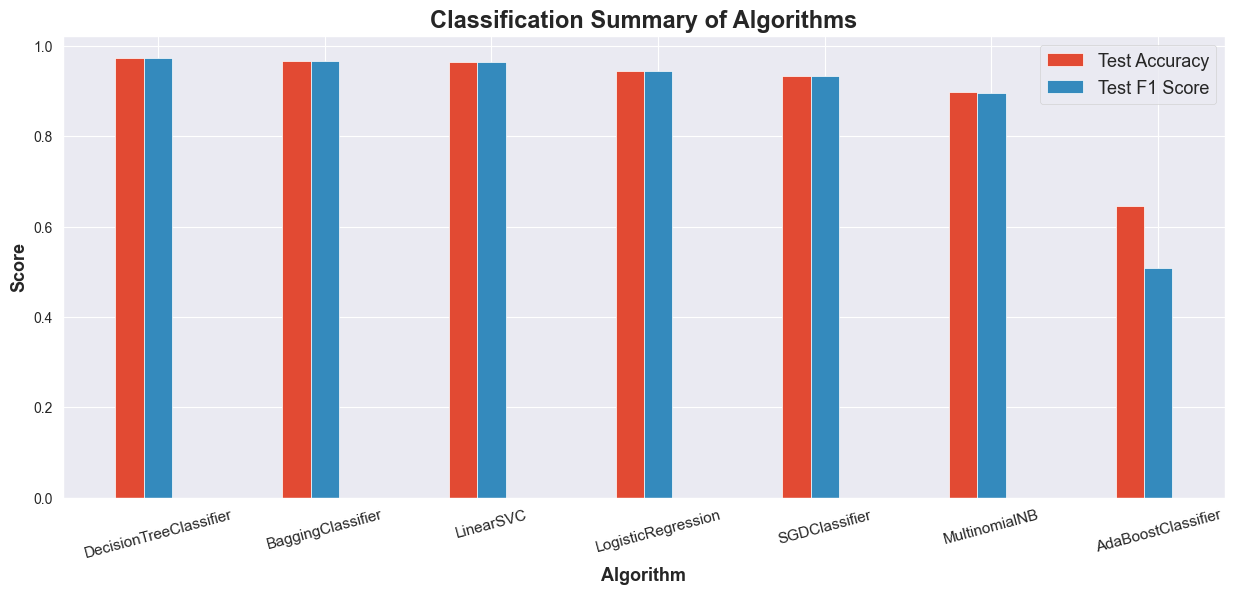

In [126]:
best_acc = results[results['Accuracy : Test'] == results['Accuracy : Test'].max()]
best_f1 = results[results['F1 Score : Test'] == results['F1 Score : Test'].max()]
best_precision = results[results['Precision : Test'] == results['Precision : Test'].max()]
best_recall = results[results['Recall : Test'] == results['Recall : Test'].max()]

sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy : Test']
bars2 = results['F1 Score : Test']

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Test F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy : Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score : Test'].values[0], best_f1['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

Training and Prediction time of Algorithm

Text(0.5, 1.0, 'Training and Prediction time of Algorithms')

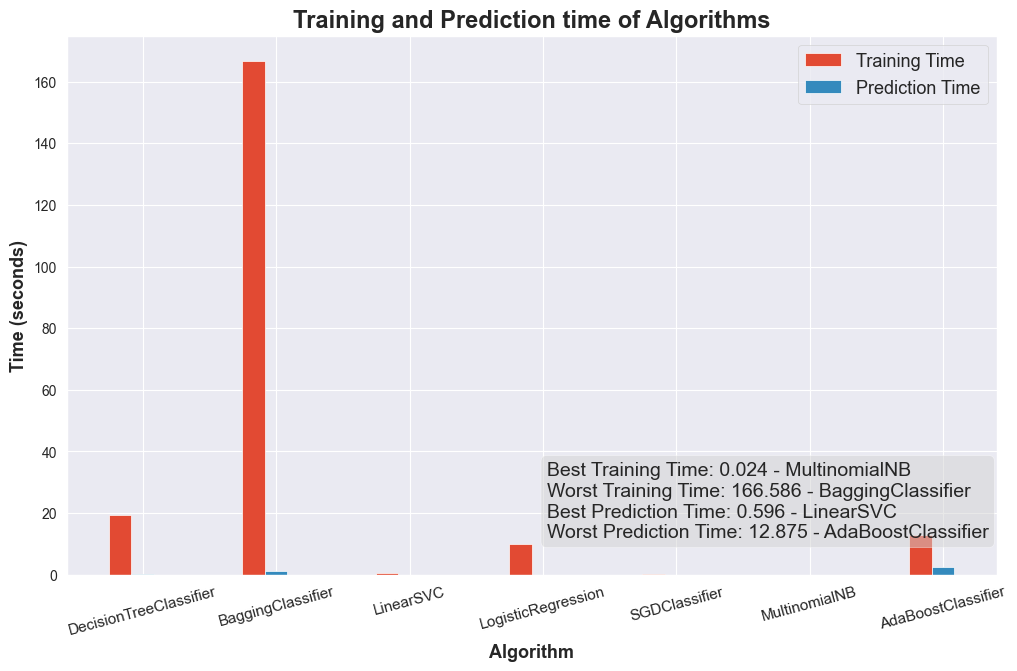

In [127]:
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)


textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(3.2, 12, textstr, fontsize=14,  bbox=props) 

# Create legend & Show graphic
plt.legend(fontsize = 13)
plt.title('Training and Prediction time of Algorithms', fontweight = 'bold', fontsize = 17)

In [128]:

df.head()

,headline,label,length_headline
0,"you are such a loser, no one cares",2,34
1,Great Job on your presentation,1,30
2,fuck your filthy mother in the ass dry,1,39
3,get fuck ed up get fuck ed up got a drink t...,1,121
4,stupid peace of shit stop deleting my stuff ...,1,93


In [132]:
data = ["you are a loser"]

tfidf_vector = TfidfVectorizer(stop_words=content_list, lowercase=True, vocabulary=pickle.load(open("tfidfvectoizer.pkl", "rb")))
preprocessed_data = tfidf_vector.fit_transform(data)

trained_model = pickle.load(open('LinearSVC.pkl', 'rb'))
print(trained_model.predict(preprocessed_data))

if(trained_model.predict(preprocessed_data)==1):
    print("bullying")
else:
    print("non-bullying")

[0]
non-bullying


Fine Tuining

In [134]:
from sklearn.model_selection import GridSearchCV

def tuining(clf, param_dict, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    
    grid_obj = GridSearchCV(estimator=clf, param_grid=param_dict, scoring=scorer, cv=5)
    
    grid_fit = grid_obj.fit(X_train, y_train)
    
    best_clf = grid_fit.best_estimator_
    
    prediction = (clf.fit(X_train, y_train)).predict(X_test)
    
    best_prediction = best_clf.predict(X_test)
    
    print(clf.__class__.__name__)
    print(f"Best Parameter:  {grid_fit.best_params_}")
    
    print(f"Accuracy:  {accuracy_score(y_test, best_prediction)}")

    print(f"F1 Score :  {f1_score(y_test, best_prediction)}")
    
    print(f"Precision :  {precision_score(y_test, best_prediction)}")
    
    print(f"Recall:  {recall_score(y_test, best_prediction)}")

In [135]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_model = LinearSVC()

tuining(clf_model, param_grid, training_data, y_train, testing_data, y_test)

C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self

LinearSVC
Best Parameter:  {'C': 0.25}
Accuracy:  0.9483471074380165
F1 Score :  0.9598027655697288
Precision :  0.9657031924072477
Recall:  0.9539740038354997


In [136]:
pickle.dump(clf_model, open("LinearSVCTuned.pkl", "wb"))